# Importaciones

In [2]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import matplotlib.pyplot as plt

In [3]:
df_pizzas_sd = pd.read_csv(r'Datawarehouse\pizzas_normales_sd.csv')

# Sarima

## Preparación de datos

In [4]:
df_pizzas_sd['fecha'] = pd.to_datetime(df_pizzas_sd['fecha'])  # Convertir a datetime
df_pizzas_sd = df_pizzas_sd.set_index('fecha')  # Establecer la fecha como índice

df_pizzas_sd.index.freq = 'MS'  # 'MS' significa inicio de mes

# Preparar los datos para el modelo ARIMA
y = df_pizzas_sd['unidades_total']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(y) * 0.8)
train, test = y[0:train_size], y[train_size:]

## Primer Modelo Sarima

In [5]:
# Suprimir advertencias específicas
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [6]:
# Ejemplo de ajuste de modelo SARIMA
order = (1, 1, 1)            # Parámetros (p, d, q) para el componente no estacional
seasonal_order = (1, 1, 1, 12)  # Parámetros (P, D, Q, s) para el componente estacional

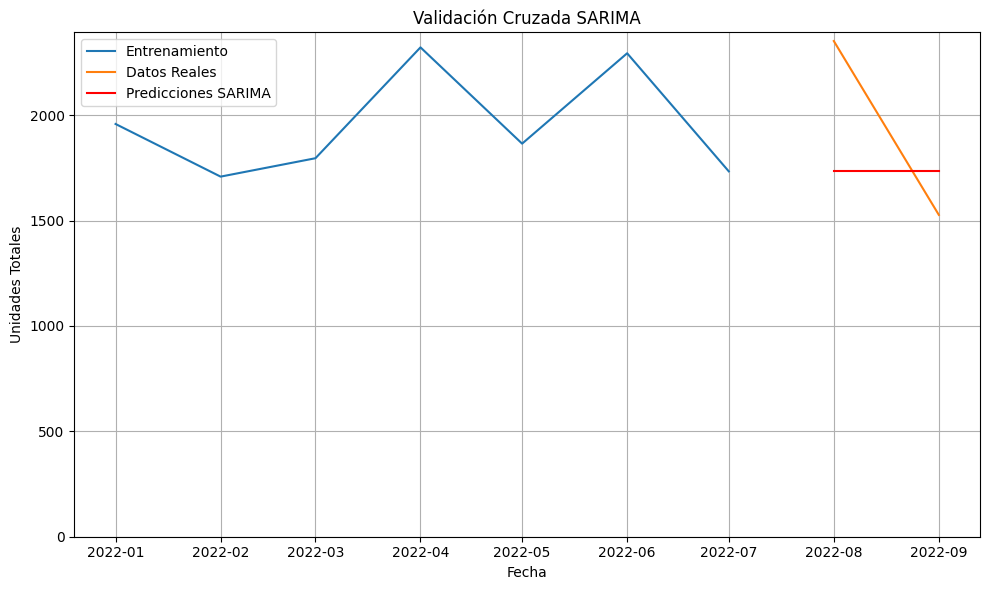

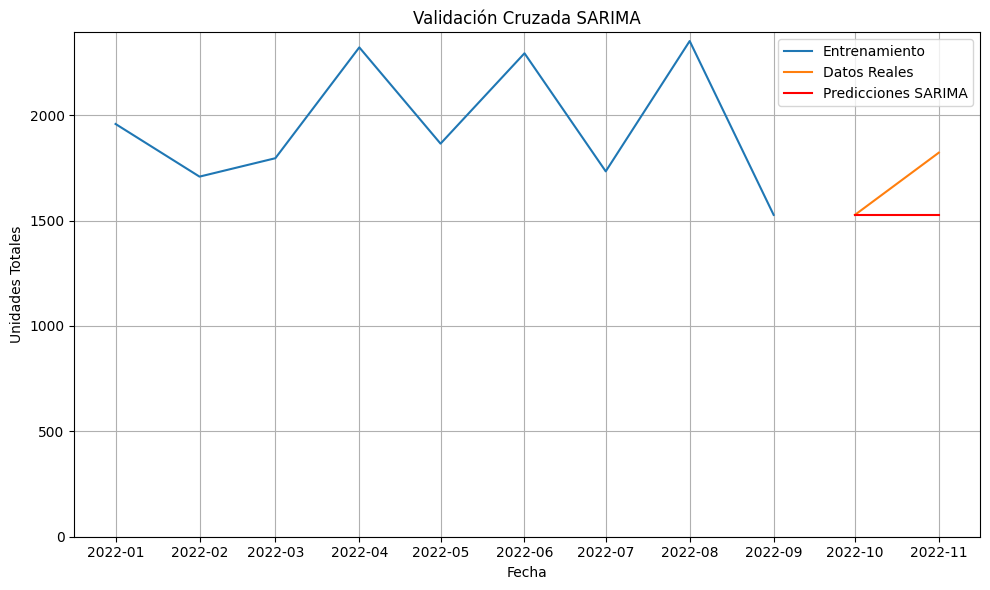

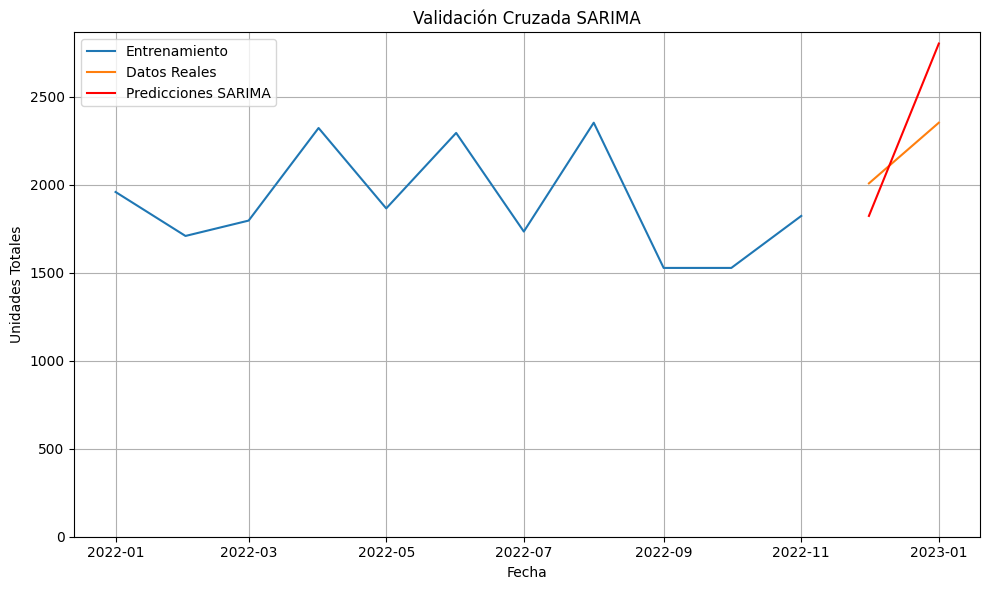

C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


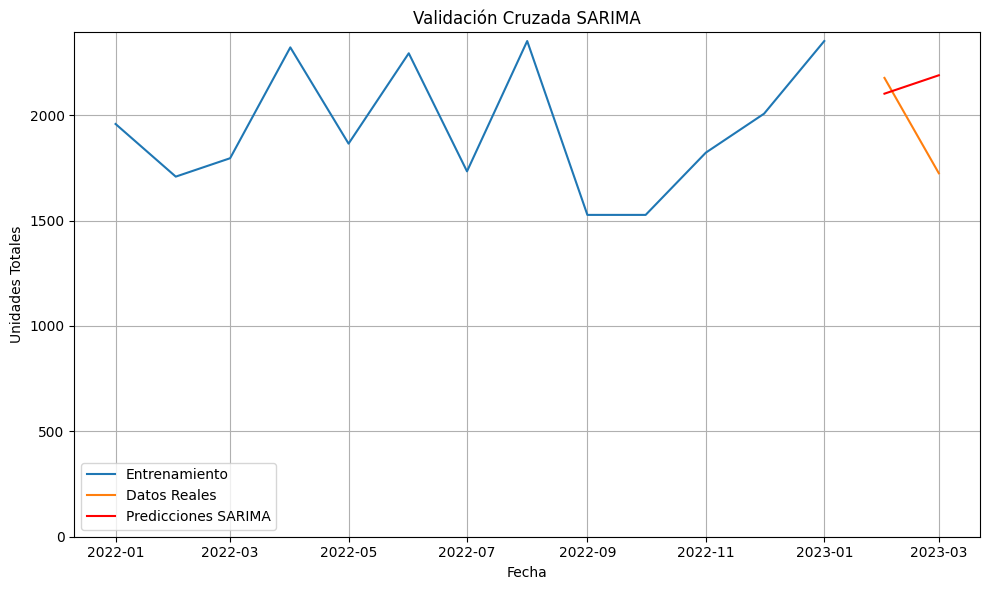

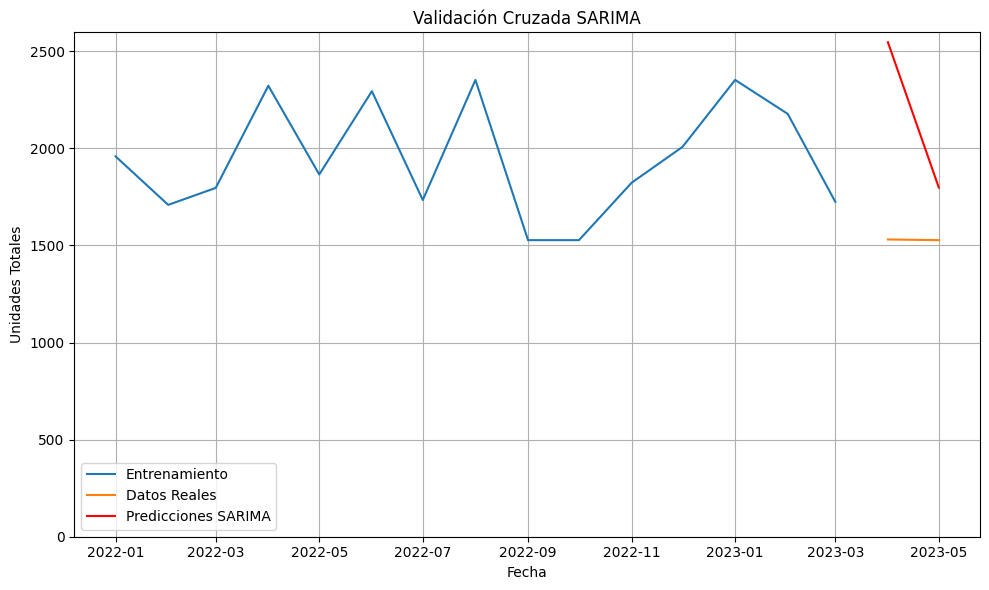

In [7]:
# Crear el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lista para almacenar los MSE de cada iteración
mse_scores = []

for train_index, test_index in tscv.split(y):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar el modelo SARIMA
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    
    # Calcular el MSE y almacenarlo
    mse = mean_squared_error(test, predictions)
    mse_scores.append(mse)

    # Graficar las predicciones vs datos reales
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Datos Reales')
    plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Totales')
    plt.title('Validación Cruzada SARIMA')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

In [8]:
# Promediar los resultados de MSE
average_mse_0 = np.mean(mse_scores)
print(f'MSE promedio: {average_mse_0}')

mse_0 = mse_scores[-1]
print(f'MSE: {mse_0}')

square_mse_0 = mse_scores[-1]**2
print(f'MSE square: {square_mse_0}')

MSE promedio: 207504.37857699377
MSE: 552265.9277607988
MSE square: 304997654965.49585


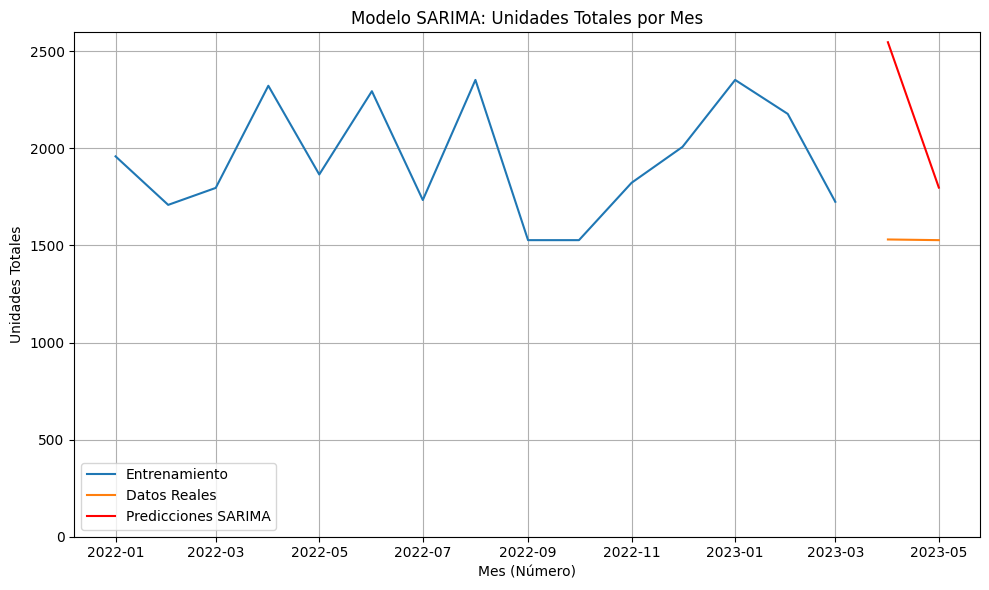

In [9]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Datos Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')

# Personalizar el gráfico
plt.xlabel('Mes (Número)')
plt.ylabel('Unidades Totales')
plt.title('Modelo SARIMA: Unidades Totales por Mes')
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

# Establecer el eje y para que comience desde cero
plt.ylim(0)

plt.tight_layout()
plt.show()

## Hiperparametrización

In [10]:
# Definir los rangos de parámetros a probar
p = range(0, 3)  # Ejemplo: probar órdenes de AR de 0 a 2
d = range(0, 2)  # Ejemplo: probar diferenciaciones de 0 a 1
q = range(0, 3)  # Ejemplo: probar órdenes de MA de 0 a 2
P = range(0, 3)  # Ejemplo: probar órdenes de AR estacional de 0 a 2
D = range(0, 2)  # Ejemplo: probar diferenciaciones estacionales de 0 a 1
Q = range(0, 3)  # Ejemplo: probar órdenes de MA estacional de 0 a 2
s = 12           # Ejemplo: frecuencia estacional (por ejemplo, 12 para datos mensuales)

# Generar todas las combinaciones posibles de parámetros
param_combinations = list(product(p, d, q, P, D, Q))

best_model = None
best_mse = np.inf

# Iterar sobre las combinaciones de parámetros
for params in param_combinations:
    try:
        model = SARIMAX(train, order=params[:3], seasonal_order=params[3:] + (s,))
        results = model.fit()
        predictions = results.forecast(steps=len(test))
        mse = mean_squared_error(test, predictions)
        
        # Actualizar el mejor modelo si se encuentra un MSE menor
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_params = params
    except:
        continue

In [ ]:
# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros SARIMA: {best_params} con MSE de {best_mse}")

Mejores parámetros SARIMA: (1, 0, 0, 0, 0, 0) con MSE de 16971.194156260302


In [ ]:
p, d, q, P, D, Q = best_params

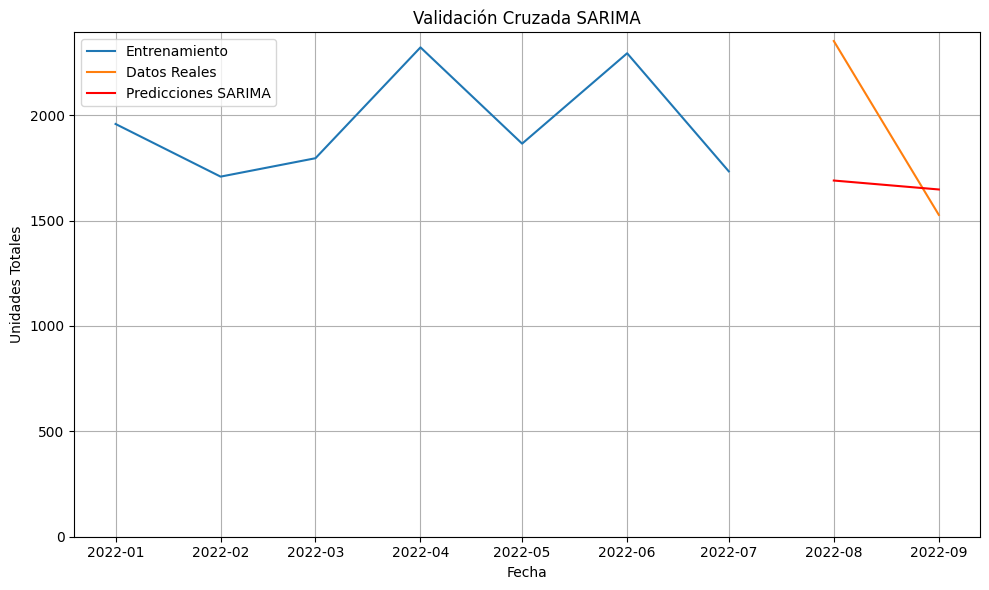

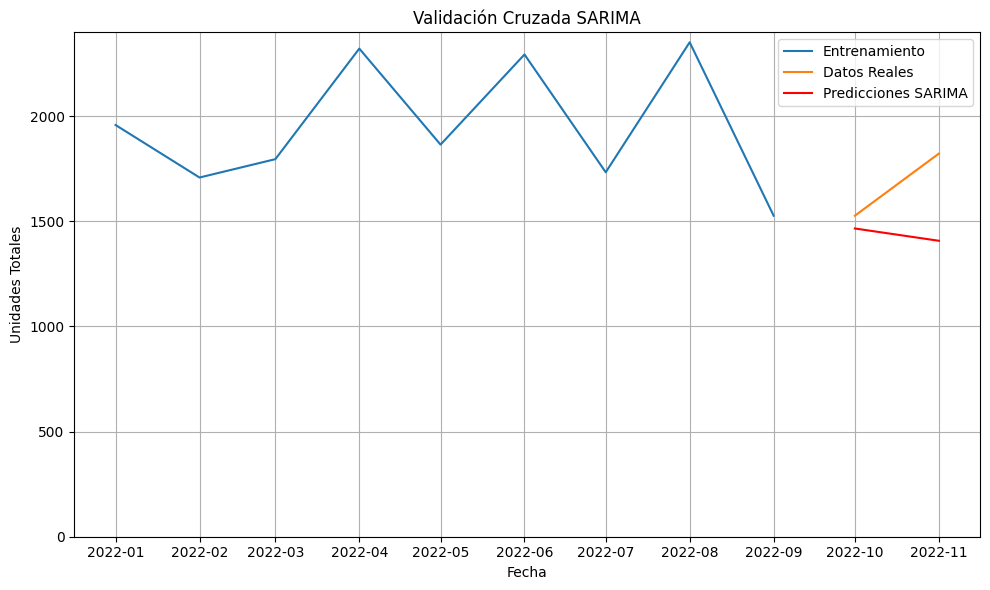

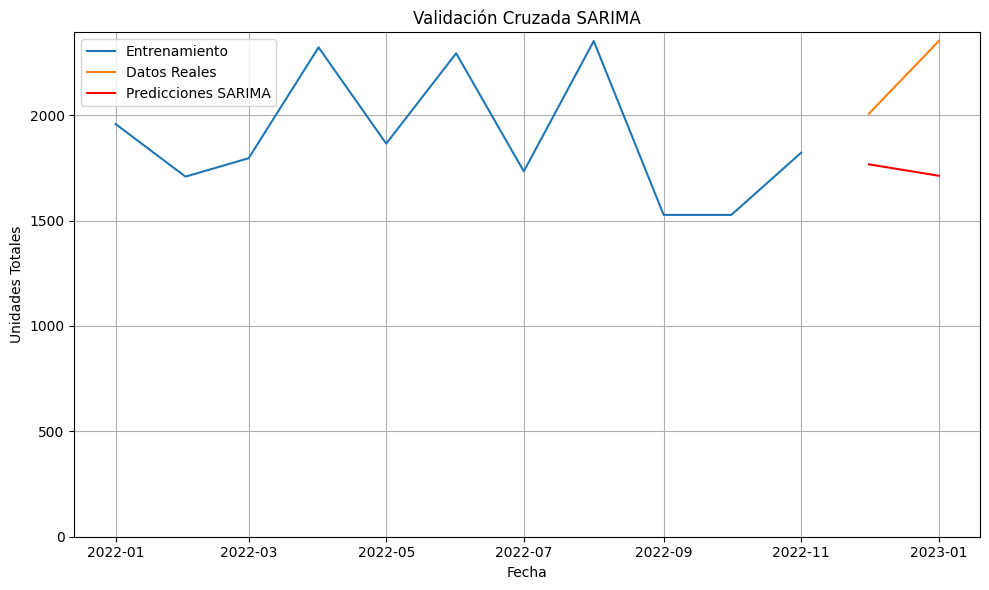

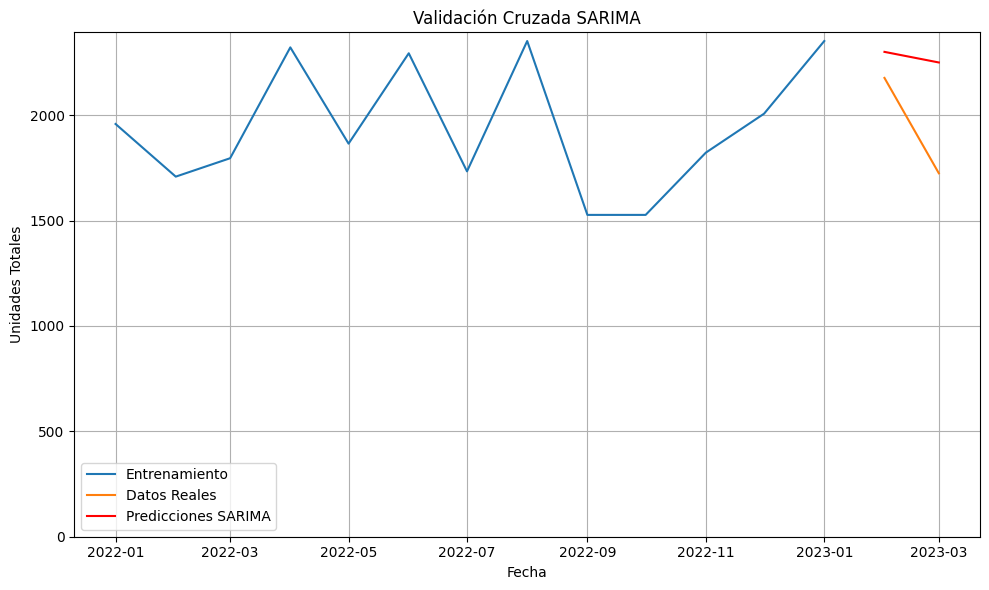

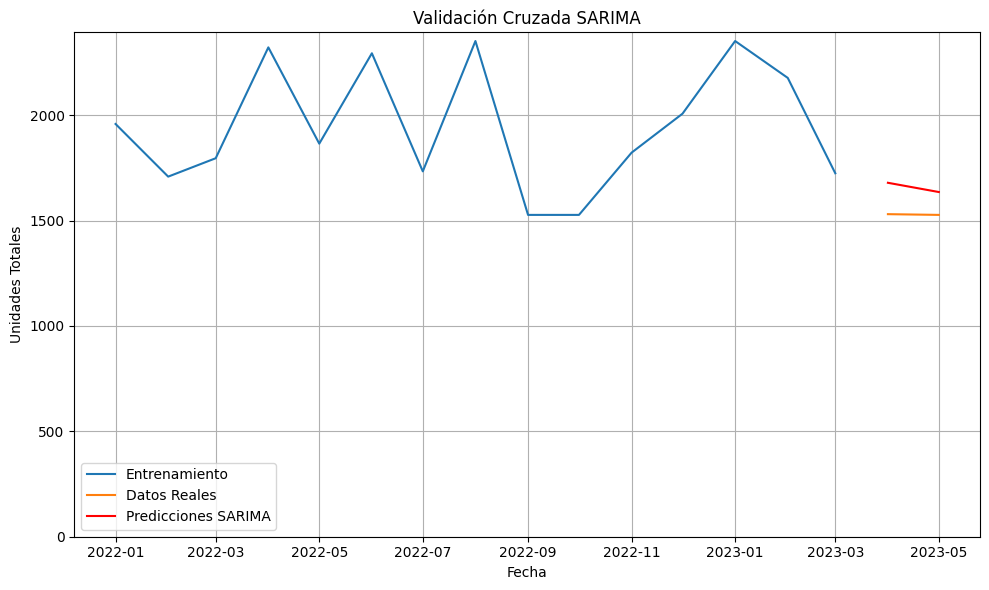

In [ ]:
# Crear el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lista para almacenar los MSE de cada iteración
mse_scores = []

for train_index, test_index in tscv.split(y):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar el modelo SARIMA
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 12))
    model_fit = model.fit(disp=False)
    
    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    
    # Calcular el MSE y almacenarlo
    mse = mean_squared_error(test, predictions)
    mse_scores.append(mse)

    # Graficar las predicciones vs datos reales
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Datos Reales')
    plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Totales')
    plt.title('Validación Cruzada SARIMA')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Promediar los resultados de MSE
average_mse_1 = np.mean(mse_scores)
print(f'MSE promedio: {average_mse_1}')

mse_1 = mse_scores[-1]
print(f'MSE: {mse_1}')

square_mse_1 = mse_scores[-1]**2
print(f'MSE square: {square_mse_1}')

MSE promedio: 142028.06796235195
MSE: 16971.194156260302
MSE square: 288021431.08948386


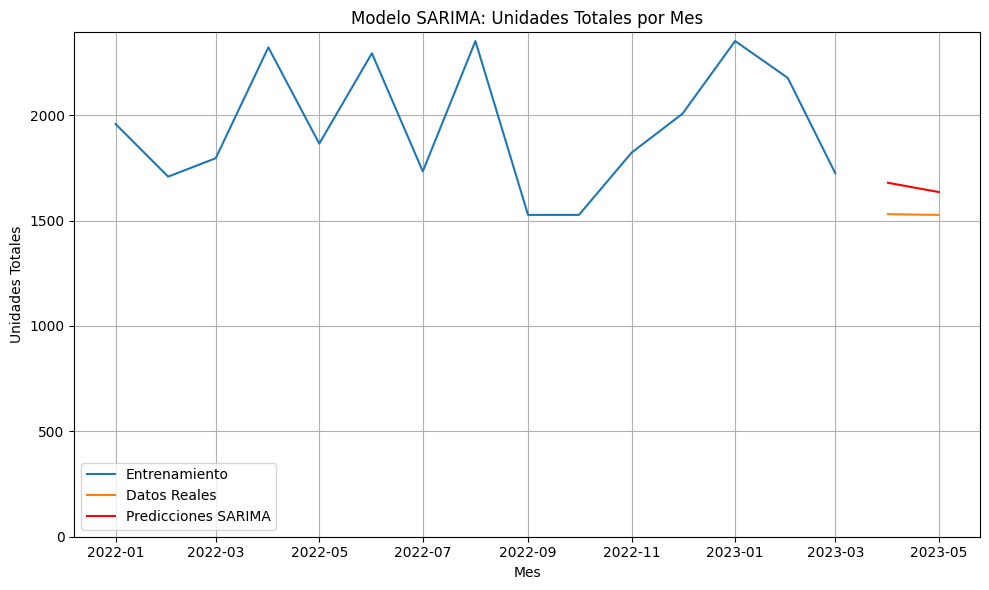

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Datos Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')

# Personalizar el gráfico
plt.xlabel('Mes')
plt.ylabel('Unidades Totales')
plt.title('Modelo SARIMA: Unidades Totales por Mes')
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

# Establecer el eje y para que comience desde cero
plt.ylim(0)

plt.tight_layout()
plt.show()

## Resultados

In [ ]:
print(f'MSE promedio sin hiperparametrizar: {average_mse_0}')
print(f'MSE sin hiperparametrizar: {mse_0}')
print(f'MSE cuadrado sin hiperparametrizar: {square_mse_0}')
print('')
print(f'MSE promedio hiperparametrizado: {average_mse_1}')
print(f'MSE hiperparametrizado: {mse_1}')
print(f'MSE cuadrado hiperparametrizado: {square_mse_1}')

NameError: name 'average_mse_0' is not defined

<div style="display: flex; justify-content: space-around;">
    <img src="Images\output.png" alt="SARIMA 1" style="width: 45%;">
    <img src="Images\output_1.png" alt="SARIMA 2" style="width: 45%;">
</div>